# Here i will show how you can use Plumed built in CV module to implement the output of an unoptimized PyTorch neural network as a collective variable!

[Plumed](plumed.github.io) is a powerful library used for running enhanced sampling simulations. It implements an very robust Collective variable module. Here I will show that you can implement a 3-layered neural network inside Plumed using its built in functions. This is possible because simpler networks are a series of linear/affine transforms 
$$y= W^Tx +b$$
plus non-linear layers(sigmoid here) 
$$\sigma(x) = \frac{1}{1+e^{-x}} $$

Both of these operations can be evaluated using the matheval library inside Plumed (skip to the end if you want the actual code)

# First an introduction to our model sysetem: Alanine dipeptide

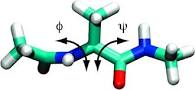

In [467]:
from IPython.display import Image
Image(filename='./helper_func/ala.jpeg')
#Image is copied from https://www.cp2k.org/_media/exercises:2014_ethz_mmm:alanine.png

In [415]:
from msmbuilder.example_datasets import AlanineDipeptide
from msmbuilder.featurizer import DihedralFeaturizer
%pylab inline
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid', palette='colorblind')
sns.set_context('talk',1.3)
import numpy as np
import sys
sys.path.insert(0, "helper_func")
%load_ext autoreload
%autoreload 2


Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[MSMBuilder](https://github.com/msmbuilder/msmbuilder) already has some alanine simulation trajectories that we can use as a starting point. 

In [19]:
traj = AlanineDipeptide().get()["trajectories"][0]

alanine_dipeptide already is cached


In [391]:
traj.save_xtc("./test_traj.xtc")

We will use the backbone dihedral features with sin-cosine transform as inputs into our nework. This leads to each simultion frame being represeneted by 4 features. 

In [468]:
f=DihedralFeaturizer(sincos=True)

# the non sin-cosine-transformed features are for visualization ONLY
plot_feat = DihedralFeaturizer(sincos=False).transform([traj])[0]
features = f.transform([traj])[0]
df = pd.DataFrame(f.describe_features(traj))


We can take a look at these features

In [30]:
features

array([[-0.6694594 , -0.74284863,  0.03690993, -0.9993186 ],
       [-0.83078104, -0.55659938,  0.38115144, -0.92451262],
       [-0.56714076, -0.82362092,  0.24837282, -0.96866453],
       ..., 
       [-0.97191048,  0.23535097,  0.48625064, -0.87381941],
       [-0.96685064,  0.2553426 ,  0.2786431 , -0.96039474],
       [-0.94193506,  0.33579513,  0.37182435, -0.92830312]], dtype=float32)

 And understand how they were calculated . For exampled feature 0 is the sin tranform of the dihedral connecting atoms [4 6 8 14]

In [33]:
df

,atominds,featuregroup,featurizer,otherinfo,resids,resnames,resseqs
0,"[4, 6, 8, 14]",phi,Dihedral,sin,"[0, 1]","[ALA, ACE]","[1, 2]"
1,"[4, 6, 8, 14]",phi,Dihedral,cos,"[0, 1]","[ALA, ACE]","[1, 2]"
2,"[6, 8, 14, 16]",psi,Dihedral,sin,"[1, 2]","[ALA, NME]","[2, 3]"
3,"[6, 8, 14, 16]",psi,Dihedral,cos,"[1, 2]","[ALA, NME]","[2, 3]"


And use the un-transformed featres to plot. 

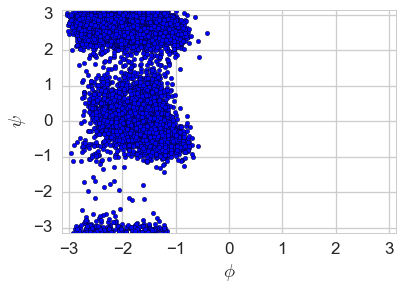

In [547]:
scatter(plot_feat[:,0],plot_feat[:,1])
xlim([-np.pi,np.pi])
ylim([-np.pi,np.pi])
xlabel(r'$\phi$')
ylabel(r'$\psi$')

#  Now begins the neural network part. Lets start by desiging a 3 layer network with a sigmoid non-linearity 

In [452]:
import torch
import torch.nn as nna
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable


# Hyper Parameters 
input_size = 4
hidden_size = 10
# The output class becomes our Plumed collective variable(CV)
num_classes = 1

In [453]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes,df):
        super(Net, self).__init__()
        self.df = df 
        self.hidden_size = hidden_size
        self.input_size = input_size
        assert len(df) == input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.l2 = nn.Sigmoid()
        self.l3 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        return out
    
net = Net(input_size, hidden_size, num_classes,df)


Run our data through it. This network is not trained so the results are not really meaningful. 

In [454]:
x = Variable(torch.from_numpy(features))

In [455]:
y = net(x)

In [471]:
nn_y = np.array(y.data.tolist())[:,0]

In [490]:
# Save network before something happens

In [491]:
torch.save(net,"nework.net")

/Users/muneeb/Documents/anaconda/lib/python3.5/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## We can visualize the networks output onto our input feature space.

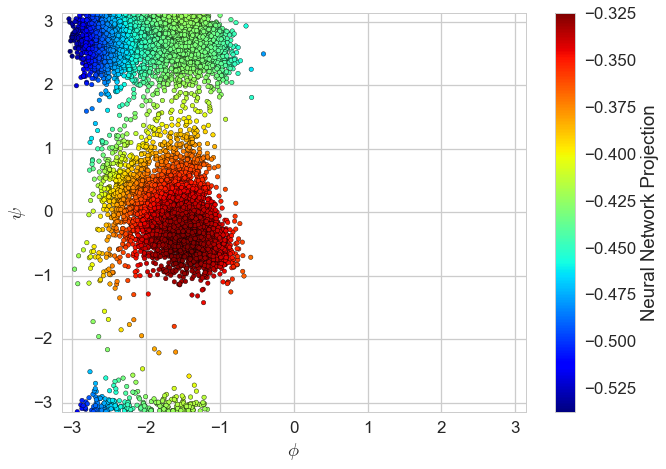

In [456]:
scatter(plot_feat[:,0],plot_feat[:,1],c=y.data.tolist(),cmap='jet')
xlim([-np.pi,np.pi])
ylim([-np.pi,np.pi])
cb = plt.colorbar()
xlabel(r'$\phi$')
ylabel(r'$\psi$')
cb.set_label("Neural Network Projection")

# Now we write the 3 layerd network into Plumed using a series of vector operations + exponential transforms

First the results!

In [479]:
print(render_network(net))

TORSION ATOMS=5,7,9,15 LABEL=phi_0_1 
TORSION ATOMS=7,9,15,17 LABEL=psi_1_2 
MATHEVAL ARG=phi_0_1 FUNC=sin(x) LABEL=l00 PERIODIC=NO 
MATHEVAL ARG=phi_0_1 FUNC=cos(x) LABEL=l01 PERIODIC=NO 
MATHEVAL ARG=psi_1_2 FUNC=sin(x) LABEL=l02 PERIODIC=NO 
MATHEVAL ARG=psi_1_2 FUNC=cos(x) LABEL=l03 PERIODIC=NO 
COMBINE LABEL=l10nb ARG=l00,l01,l02,l03 COEFFICIENTS=-0.3953005075454712,-0.08696779608726501,0.2848997414112091,-0.44831323623657227 PERIODIC=NO 
MATHEVAL ARG=l10nb FUNC=x+0.36086708307266235 LABEL=l10 PERIODIC=NO 
COMBINE LABEL=l11nb ARG=l00,l01,l02,l03 COEFFICIENTS=-0.11382120102643967,0.2005525529384613,0.46498095989227295,-0.1768099069595337 PERIODIC=NO 
MATHEVAL ARG=l11nb FUNC=x+0.0779024288058281 LABEL=l11 PERIODIC=NO 
COMBINE LABEL=l12nb ARG=l00,l01,l02,l03 COEFFICIENTS=0.29022225737571716,-0.23747512698173523,0.26733818650245667,0.2071552723646164 PERIODIC=NO 
MATHEVAL ARG=l12nb FUNC=x+0.40114668011665344 LABEL=l12 PERIODIC=NO 
COMBINE LABEL=l13nb ARG=l00,l01,l02,l03 COEFFICIENTS=0

# The entire network can be programmatically generated to depend on the output of the previous layer/s

In [550]:
# this creates the feature extractor 
def write_df(df):
    inds = range(len(df))
    already_done_list = []
    output = []
    
    for j in df.iloc[inds].iterrows():
        feature_index = j[0]
        atominds = np.array(j[1]["atominds"])
        resids = j[1]["resids"]
        feat = j[1]["featuregroup"]
        func = get_feature_function(df, feature_index)
        
        feat_label = feat+"_%s"%'_'.join(map(str,resids))

        if feat_label not in already_done_list:
            #mdtraj is 0 indexed and plumed is 1 indexed
            output.append(func(atominds + 1 , feat_label))
            already_done_list.append(feat_label)
            
    for j in df.iloc[inds].iterrows():
        feature_index = j[0]
        atominds = j[1]["atominds"]
        feat = j[1]["featuregroup"]
        resids = j[1]["resids"]
        feat = j[1]["featuregroup"]        
        argument = feat+"_%s"%'_'.join(map(str,resids))
        label = "l0%d"%feature_index
        
        output.append(create_feature(argument, df.otherinfo[feature_index], label))
        output.append("\n")
    
    return ''.join(output)

# this creates a fully connected layer
def render_fc_layer(layer_indx, lp):
    output=[]
    for i in np.arange(lp.out_features):
        
        arg=','.join(["l%d%d"%(layer_indx-1,j) for j in range(lp.in_features)])
        
        weights = ','.join(map(str,lp.weight[i].data.tolist()))
        bias =','.join(map(str,lp.bias[i].data.tolist()))
        
        # combine without bias
        non_bias_label = "l%d%dnb"%(layer_indx, i)
        output.append(plumed_combine_template.render(arg = arg,
                                   coefficients = weights,
                                   label=non_bias_label,
                                   periodic="NO") +"\n")
        # now add the bias
        bias_label = "l%d%d"%(layer_indx, i)
        output.append(create_neural_bias(non_bias_label, bias, bias_label))
        output.append("\n")
    return ''.join(output)
    
    
# this cretes a sigmoid layer
def render_sigmoid_layer(layer_indx, lp, hidden_size=50):
    output=[]    
    for i in np.arange(hidden_size):
        arg="l%d%d"%(layer_indx-1, i)
        label = "l%d%d"%(layer_indx, i)
        output.append(create_sigmoid(arg, label))
        output.append("\n")
        
    return ''.join(output)

# All we need to do is decide what type of layer , we are on and call the appropriate function

In [551]:
def render_network(net):
    output =[]
    # Start by evaluating the actual dihedrals + sin-cosine transform aka the input features 
    output.append(write_df(net.df))
    index = 0
    # Go over every layer of the netowrk
    for lp in net.children():
        index += 1
        if str(lp).startswith("Linear"):
            output.append(render_fc_layer(index, lp))
        elif str(lp).startswith("Sigmoid"):
            output.append(render_sigmoid_layer(index, lp,hidden_size=net.hidden_size))
        else:
            raise ValueError("Only Linear and Sigmoid Layers are supported for now")
    # Lastly, we want to print out the values from the last layer. This becomes our CV. 
    arg = "l%d0"%index
    output.append(render_print_val(arg))
    return ''.join(output)

In [532]:
# to call it 
# output =  render_network(net)

# We can now run Plumed locally or on a compute cluster and then compare its output to our PyTorch implementation

In [461]:
# the 0th column in plumeds' CV file is always 
plumed_vals = np.loadtxt("CV")

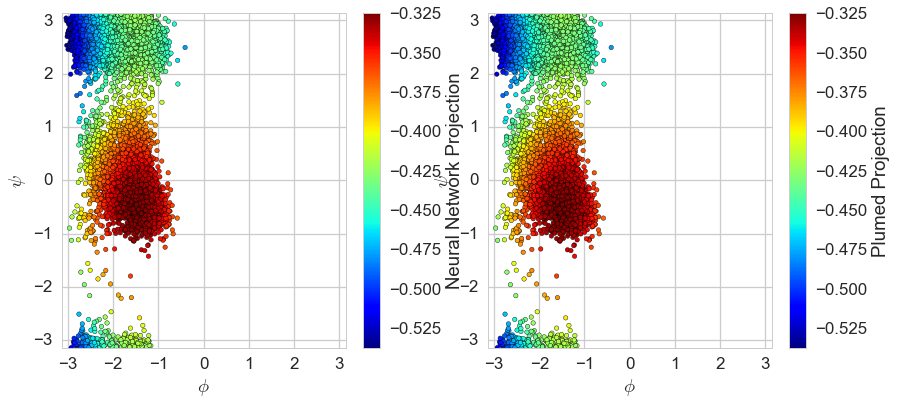

In [509]:
figure(figsize=(14,6))
subplot(1,2,1)
scatter(plot_feat[:,0],plot_feat[:,1],c=nn_y,cmap='jet')
xlim([-np.pi,np.pi])
ylim([-np.pi,np.pi])
cb = plt.colorbar()
xlabel(r'$\phi$')
ylabel(r'$\psi$')
cb.set_label("Neural Network Projection")

subplot(1,2,2)
scatter(plot_feat[:,0],plot_feat[:,1],c=plumed_vals[:,1],cmap='jet')
xlim([-np.pi,np.pi])
ylim([-np.pi,np.pi])
cb = plt.colorbar()
xlabel(r'$\phi$')
ylabel(r'$\psi$')
cb.set_label("Plumed Projection")

Or do a scatter plot to make sure that they are equal. 

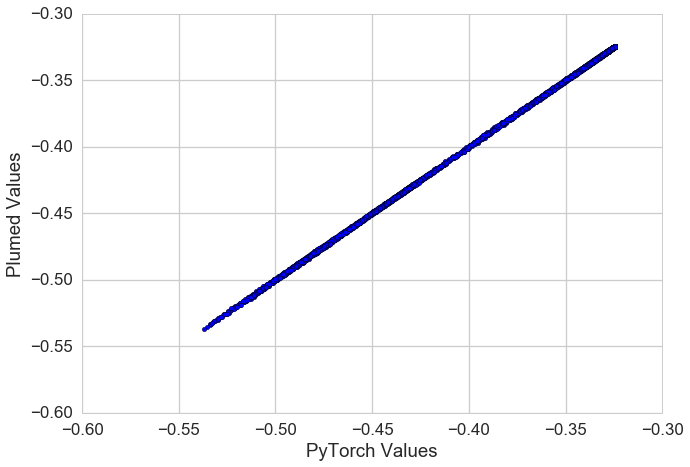

In [464]:
plt.scatter(nn_y,plumed_vals[:,1])
plt.xlabel("PyTorch Values")
plt.ylabel("Plumed Values")

# Perhaps most remarkably, we can now sample this un-optimized neural network's output using Plumed's implementation of well temperated metadynamics. For our case, we are running simulations using OpenMM. 

To do that we need to add the following lines at the end of our network script

METAD ARG=l30 SIGMA=0.2 HEIGHT=1 BIASFACTOR=20 TEMP=300 FILE=HILLS PACE=1000 LABEL=metad 

PRINT ARG=l30,metad.bias STRIDE=1000 FILE=BIAS.0


## Thats it! We are now ready to simulate! 

The simulations were run on Stanford's X-stream GPU cluster using a single K40. The simulation speed was about 120-125ns/day. The results are stored in the plumed traj folder. To run them, 

In [492]:
import mdtraj as md

In [552]:
plumed_traj = md.load("./plumed_traj/trajectory.dcd",top="./plumed_traj/solvated_ala.pdb")

In [553]:
plumed_traj_feat = DihedralFeaturizer(sincos=True).transform([plumed_traj])[0]
plumed_traj_plot_feat = DihedralFeaturizer(sincos=False).transform([plumed_traj])[0]

In [554]:
x_plumed = Variable(torch.from_numpy(plumed_traj_feat))
y_plumed = net(x_plumed)
nn_y_plumed = np.array(y_plumed.data.tolist())[:,0]

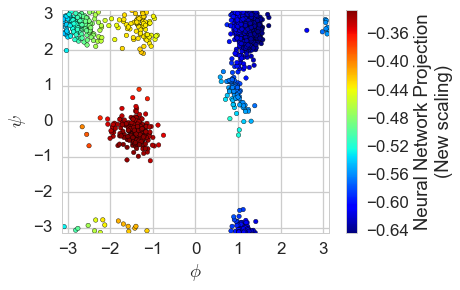

In [555]:
scatter(plumed_traj_plot_feat[:,0],plumed_traj_plot_feat[:,1],c=nn_y_plumed,cmap='jet')
xlim([-np.pi,np.pi])
ylim([-np.pi,np.pi])
cb = colorbar()
xlabel(r'$\phi$')
ylabel(r'$\psi$')
cb.set_label("Neural Network Projection\n(New scaling)")

# Amazingly our network CV has now discovered a new basin that wasnt in the original data.

 lets plot a trajectory trace to see what happens as simulation progress

(-0.65, -0.3)

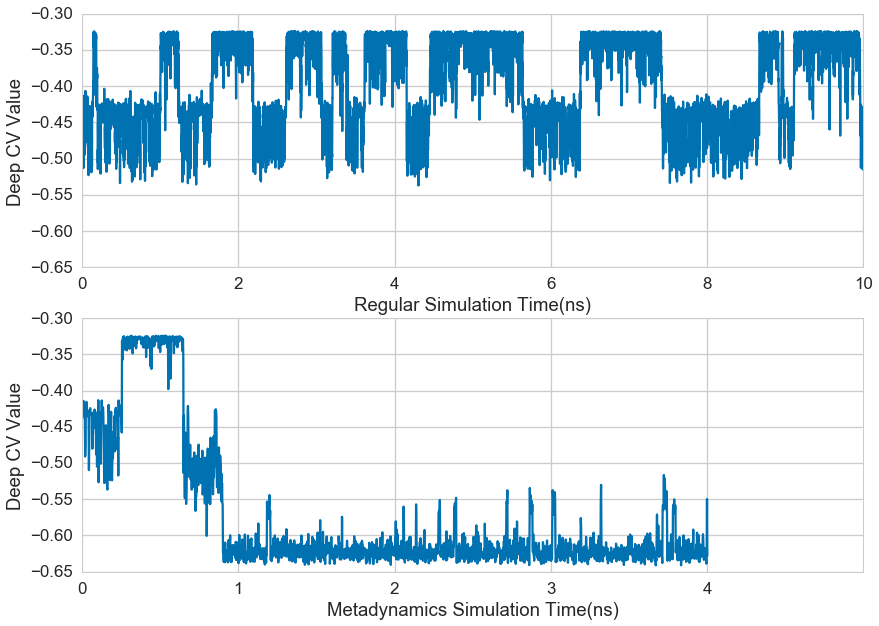

In [561]:
figure(figsize=(14,10))
subplot(2,1,1)
plot(nn_y)
# msmbuilder ala sims are saved every ps
xticks([0,2000,4000,6000,8000,10000],[0,2,4,6,8,10])
ylim([-.65,-.3])
xlabel("Regular Simulation Time(ns)")
ylabel("Deep CV Value")

subplot(2,1,2)
plot(nn_y_plumed)
# our plumed sims are saved every 2ps 
xticks([0,500,1000,1500,2000],[0,1,2,3,4])
xlabel("Metadynamics Simulation Time(ns)")
ylabel("Deep CV Value")
ylim([-.65,-.3])


As it can be seen, we can sample the CV much faster if we use metadynamics in this scenario. However, this is not necesarily the case in most larger systems. More so, our CV is suffering from hystersis,because it is unable to come back from the lower end of the CV. But CV optimization is a different topic altogether. 

# Other helper functions 

In [149]:
from jinja2 import Template

In [386]:
plumed_torsion_template = Template("TORSION ATOMS={{atoms}} LABEL={{label}} ")

plumed_matheval_template = Template("MATHEVAL ARG={{arg}} FUNC={{func}} LABEL={{label}} PERIODIC={{periodic}} ")

plumed_combine_template = Template("COMBINE LABEL={{label}} ARG={{arg}} COEFFICIENTS={{coefficients}} "+\
                                    "PERIODIC={{periodic}} ")
plumed_print_template = Template("PRINT ARG={{arg}} STRIDE={{stride}} FILE={{file}} ")


In [395]:
def create_torsion_label(inds, label):
    #t: TORSION ATOMS=inds
    return plumed_torsion_template.render(atoms=','.join(map(str, inds)), label=label) +"\n"


def create_feature(argument, func, feature_label):
    arg = argument
    x="x"
    if func in ["sin","cos"]:
        f = "%s(%s)"%(func,x)
        label = feature_label
    else:
        raise ValueError("Can't find function")

    return plumed_matheval_template.render(arg=arg, func=f,\
                                           label=label,periodic="NO")


def create_neural_bias(nb, bias, label):
    arg = ",".join([nb])
    f = "+".join(["x", bias])
    return plumed_matheval_template.render(arg=arg, func=f,\
                                           label=label,periodic="NO")
def create_sigmoid(arg, label):
    f = "1/(1+exp(-x))"
    return plumed_matheval_template.render(arg=arg, func=f,\
                                           label=label,periodic="NO")

def render_print_val(arg,stride=1,file="CV"):
    return plumed_print_template.render(arg=arg,
                                       stride=stride,
                                       file=file)


In [477]:
def get_feature_function(df, feature_index):
    possibles = globals().copy()
    possibles.update(locals())
    func = possibles.get("create_torsion_label")
    return func

In [474]:
def match_mean_free_function(df, feature_index):
    func = df.otherinfo[feature_index]
    return func